# Ch 7 K-nearest neighbors with dynamic
# time warping

In [ ]:
#pip install tsfresh tslearn

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "17"

In [1]:
# download dataset of robotic execution faiures from UCI machine learning repository
# dataset has force and torque measurements from a robot after a failure was detected
from tsfresh.examples import load_robot_execution_failures
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures

download_robot_execution_failures()
df_ts, y = load_robot_execution_failures()

In [2]:
print(f"{y.mean():.2f}")

0.24


In [3]:
#columns include the time and six time-series with signals from the sensors,
#F_x, F_y, F_z, T_x, T_y, and T_z. 
# The target variable, y, is True or False, indicates if there was a failure

In [4]:
df_ts.head()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


In [11]:
#extract time-series features using TSFresh
# impute missing values and select features based on relevance to the target.
#the p-value from a statistical test is used to calculate the feature significance:
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

extracted_features = impute(extract_features(df_ts, column_id="id", column_sort="time"))
features_filtered = select_features(extracted_features, y)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]
C:\Users\hp\anaconda3\lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__matrix_profile__feature_"median"__threshold_0.98'
 'T_z__matrix_profile__feature_"25"__threshold_0.98'
 'T_z__matrix_profile__feature_"75"__threshold_0.98'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [13]:
from tsfresh.transformers import RelevantFeatureAugmenter
import pandas as pd

X = pd.DataFrame(index=y.index)
TRAINING_SIZE = (len(X) // 10) * 8
augmenter = RelevantFeatureAugmenter(column_id='id', column_sort='time')
augmenter.set_timeseries_container(df_ts[:TRAINING_SIZE])
augmenter.fit(X[:TRAINING_SIZE], y[:TRAINING_SIZE])
X_transformed = augmenter.transform(X)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.27it/s]
C:\Users\hp\anaconda3\lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['T_x__partial_autocorrelation__lag_7'
 'T_x__partial_autocorrelation__lag_8'
 'T_x__partial_autocorrelation__lag_9' ...
 'F_z__matrix_profile__feature_"median"__threshold_0.98'
 'F_z__matrix_profile__feature_"25"__threshold_0.98'
 'F_z__matrix_profile__feature_"75"__threshold_0.98'] did not have any finite values. Filling with zeros.
  warnings.warn(
Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.79it/s]


In [14]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier()
param_search = {
    'metric' : ['dtw'],  # ctw', 'dtw', "softdtw"], # TSLEARN_VALID_METRICS}
    'n_neighbors': [1, 2, 3]
}
#  'param_grid': {'metric': ['ctw', 'dtw', 'gak', 'sax', 'softdtw', 'lcss']},
tscv = TimeSeriesSplit(n_splits=2)

gsearch = GridSearchCV(
    estimator=knn,
    cv=tscv,
    param_grid=param_search
)
gsearch.fit(
    features_filtered,
    y
)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=KNeighborsTimeSeriesClassifier(),
             param_grid={'metric': ['dtw'], 'n_neighbors': [1, 2, 3]})

In [15]:
import seaborn as sns
import pandas as pd

def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return fig

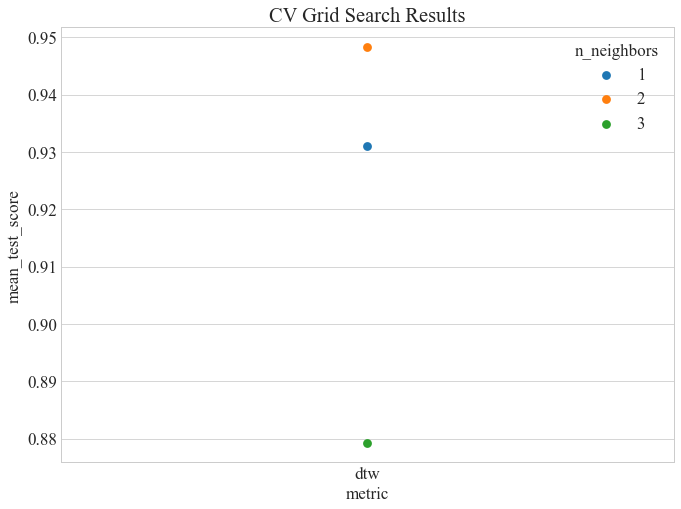

In [16]:
fig = plot_cv_results(gsearch.cv_results_, 'metric', 'n_neighbors')